In [1]:
import cv2
import numpy as np
import imutils
from imutils import paths
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Image stitching

Bài toán này có thể được giải quyết theo cách truyền thống:

1. `Phát hiện keypoints và các descriptors tương ứng đại diện cho tính duy nhất của keypoint`
2. `So khớp các keypoints dựa trên descriptors`
3. `Tính toán ma trận homography dựa trên các keypoints được so khớp với nhau`
4. `Có được ảnh biến đổi từ ma trận homography`

In [3]:
def detectAndDescribe(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # chuyển sang ảnh gray vì SIFT được sử dụng chủ yếu cho ảnh này
    sift = cv2.SIFT_create() # khởi tạo SIFT detector
    (kpts, descs) = sift.detectAndCompute(gray_image, None)
    # trả về một tuple gồm keypoints và descriptors tương ứng
    return [keypoint.pt for keypoint in kpts], descs # vì kpts là một class nên cần lấy vị trí pixel

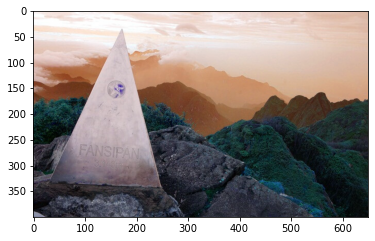

In [4]:
fansipan = cv2.imread('images/fansipan/vietnam_fansipan.jpg')  
plt.imshow(fansipan)
plt.show()

In [5]:
kpts, descs = detectAndDescribe(fansipan)

In [6]:
for kpt, desc in zip(kpts[:2], descs[:2]):
    print(kpt, desc, len(desc), sep='\n')

(2.434461832046509, 311.1641540527344)
[ 39.  42.  66.  36.   8.   3.   0.   0. 177. 156.   8.   2.   3.   0.
   0.   6.  79.  40.   5.   7. 105.  30.   5.  10.  60.  18.   8.   2.
  19.  13.  10.  22.  62.  14.  27.   8.   0.   6.  31.  48. 177.  36.
   2.   0.   0.   1.   9.  99. 116.  12.   1.   4.  24.  52.  40.  58.
   6.   2.   5.   9.  52.  53.  40.  29.  15.   0.   0.   0.  10.  97.
  96. 100. 177.  46.   1.   1.   0.   0.  23. 100. 104.  45.  10.  13.
  12.  12.   5.  14.  14.   0.   0.   1.  32.  43.   6.  13.   0.   0.
   0.   0.  11.  33.   9.  11.  16.   3.   0.   0.   0.   0.   3.  10.
   5.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
128
(2.6007914543151855, 301.17755126953125)
[ 24.  29.   6.   2.   5.   5.   0.   5. 151.  29.   1.   0.   0.   0.
   3. 151.  28.   1.   0.   0.   0.   0.   5.  95.   0.   0.   0.   0.
   0.   0.   0.   0.  76.   3.   1.   1.  18.  42.   6.  22. 151.  29.
   2.   1.   0.   0.   1. 143.  85.  15.   8.  29.  

`Vị trí pixel gồm tung độ và hoành độ (y, x)` (cách hiển thị mặc định của ảnh) <br>
`Với mỗi vị trí thì gồm một vector nêu lên đặt trưng duy nhất của điểm đó, mỗi giá trị trong vector thể hiện độ mạnh, yếu theo hướng đó` <br>
`Độ dài của vector(hướng) là 128 vì đây sử dụng SIFT, sẽ khác nếu sử dụng detector khác`

In [7]:
def matchKeypoints(descA, descB, kptsA, kptsB):
    matcher = cv2.BFMatcher() # khởi tạo brute force matcher, vét cạn tất cả các trường hợp
    matches = matcher.knnMatch(descA, descB, k=2)
    # sử dụng K vùng lân cận để tính so khớp chính xác hơn 
    # thay vì chỉ lấy trình khoảng cách bé nhất của hai descriptor
    
    good = [] # theo Lowe's test, với mỗi descriptor ta tìm thấy 2 descriptor của ảnh khác tương đồng nhất
    # (2 khoảng cách bé nhất) và sau đó dựa trên công thức nếu cặp keypoints thoả: bé nhất < ratio * bé nhì thì
    # đây là một một cặp có xác suất đúng cao hơn (ratio dao động từ 0.7 - 0.8)
    for first, second in matches: 
        if first.distance < 0.75 * second.distance:
            good.append((first.queryIdx, first.trainIdx)) # gồm một cặp thứ tự: (ảnh đích, ảnh nguồn)
            
    if len(good) > 4: # để tìm được ma trận homography thì cần ít nhất là 5 điểm tương đồng
        ptsA, ptsB = [], []
        
        for src, desc in good:
            ptsA.append(kptsA[src])
            ptsB.append(kptsB[desc])
        
        H, status = cv2.findHomography(np.float32(ptsA), np.float32(ptsB), cv2.RANSAC, 5.0)
        # hàm trả về ma trận homography, status nói lên điểm đó là false match hay correct match, nếu trong automatic
        # panorama stitching thì cần phải sử dụng mảng status để tính toán mô hình kiểm định so khớp ngẫu nhiên có thành
        # công hay không
        # Ở đây thì không cần sử dụng
        
        return H
    
    return None # nếu khổng đủ điểm tương đồng thì trả về None

In [8]:
def show_images(A, B):
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(8, 5))
    ax1.imshow(A)
    ax2.imshow(B)
    plt.show()

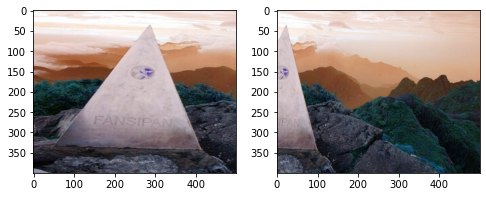

((400, 500, 3), (400, 500, 3))

In [9]:
left_fansipan = cv2.imread('images/fansipan/left_fansipan.jpg')
right_fansipan = cv2.imread('images/fansipan/right_fansipan.jpg')

show_images(left_fansipan, right_fansipan)

left_fansipan.shape, right_fansipan.shape

In [10]:
(kptsA, descA) = detectAndDescribe(left_fansipan)
(kptsB, descB) = detectAndDescribe(right_fansipan)
H = matchKeypoints(descA, descB, kptsA, kptsB)
H # ma trận 3 x 3

array([[ 6.02878274e-01, -2.30436873e-03, -1.49877103e+02],
       [ 5.80928552e-03,  1.00290485e+00, -1.68117847e+00],
       [ 1.90588738e-05, -7.72245447e-06,  1.00000000e+00]])

`Đưa tất cả vào một class để tính toán thuận tiện`

In [11]:
class Stitcher:
    def __init__(self, ratio=0.75, reprojThresh=5.0, final_image=True, rotated=False):
        self.ratio = ratio
        self.reprojThresh = reprojThresh
        self.final_image = final_image
        self.rotated = rotated
    
    def stitch(self, imageA, imageB):
        (kptsA, descA) = self.detectAndDescribe(imageA) 
        (kptsB, descB) = self.detectAndDescribe(imageB)

        M = self.matchKeypoints(descA, descB, kptsA, kptsB)
        
        if M is None:
            return None

        H = M
        if self.rotated:
            stitched_image = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0] \
                                                            + imageB.shape[0]))
        else:
             stitched_image = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        # có ma trận biến đổi, có ảnh ban đầu -> ảnh biến đổi
        if self.final_image:
            stitched_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB # phần trống là ảnh còn lại 
    
        return stitched_image
    
    def detectAndDescribe(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        (kpts, descs) = sift.detectAndCompute(gray, None)

        return [keypoint.pt for keypoint in kpts], descs
    
    def matchKeypoints(self, descA, descB, kptsA, kptsB):
        matcher = cv2.BFMatcher() 
        matches = matcher.knnMatch(descA, descB, k=2)


        good = [] 
        for first, second in matches: 
            if first.distance < self.ratio * second.distance:
                good.append((first.queryIdx, first.trainIdx))

        if len(good) > 4: 
            ptsA, ptsB = [], []

            for src, desc in good:
                ptsA.append(kptsA[src])
                ptsB.append(kptsB[desc])

            H, _ = cv2.findHomography(np.float32(ptsA), np.float32(ptsB), cv2.RANSAC, self.reprojThresh)


            return H
    
        return None 

In [12]:
stitcher = Stitcher()

In [13]:
stitched = stitcher.stitch(right_fansipan, left_fansipan)

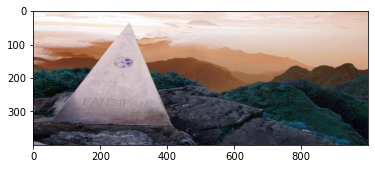

In [14]:
plt.imshow(stitched)
plt.show() # Kết quả thành công

### Thử nghiệm

`Thử nghiệm trên cùng một bộ ảnh với các tính chất khác nhau`

#### Thứ tự ảnh

Như ở trên, ta lấy ảnh **trùng phần bên trái so khớp với ảnh trùng phần bên phải**. Giờ thử ngược lại và xem kết quả thế nào?

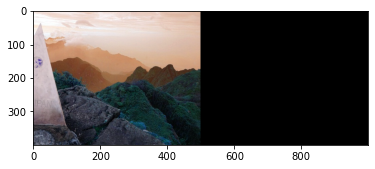

In [15]:
stitched_right_to_left = stitcher.stitch(left_fansipan, right_fansipan)
plt.imshow(stitched_right_to_left)
plt.show()

Kết quả không được như mong đợi :(

`Lí do`

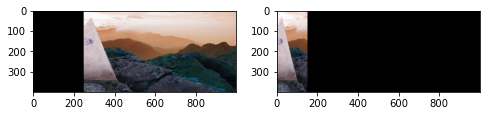

In [16]:
stitcher = Stitcher(final_image=False)
stitched_left_to_right = stitcher.stitch(right_fansipan, left_fansipan)
stitched_right_to_left = stitcher.stitch(left_fansipan, right_fansipan)


show_images(stitched_left_to_right, stitched_right_to_left)

Ta sẽ thấy sau khi thực hiện ma trận biến đổi homography thì **ảnh trùng phần bên phải để so khớp** chỉ có lấy **duy nhất** phần chung mà mất đi giá trị pixel ảnh đó.

`Stitching image cơ bản cần thứ tự của ảnh` **trùng trái sang phải**

`Một nhược điểm nữa là`, nếu có nhiều ảnh thì ta phải làm **thủ công** từng **đôi một**

#### Kích thước khác nhau

Nếu chiều cao khác nhau chắc chắn sẽ không được vì khi chèn pixels sẽ bị sai, ta sẽ thử với giá trị chiều rộng khác nhau

In [17]:
left_fansipan.shape, right_fansipan.shape # Ban đầu hai ảnh có kích thước là như nhau

((400, 500, 3), (400, 500, 3))

In [18]:
left_fansipan_resize_width = cv2.resize(left_fansipan, (600, 400))
left_fansipan_resize_width.shape

(400, 600, 3)

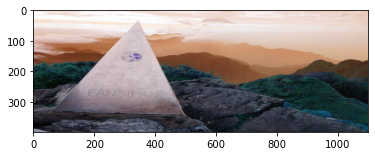

In [19]:
stitcher = Stitcher()
resized_width = stitcher.stitch(right_fansipan, left_fansipan_resize_width)
plt.imshow(resized_width)
plt.show()

Thử thêm một cái khác nữa!!

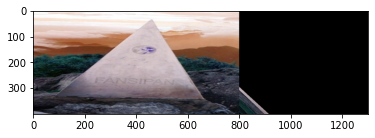

In [20]:
left_fansipan_resize_width = cv2.resize(left_fansipan, (800, 400))
left_fansipan_resize_width.shape

resized_width = stitcher.stitch(right_fansipan, left_fansipan_resize_width)
plt.imshow(resized_width)
plt.show()

Ảnh không khớp, `như vậy thuật toán không đảm bảo kết quả đúng nếu kích thước khác nhau khá lớn`

#### Xoay ảnh

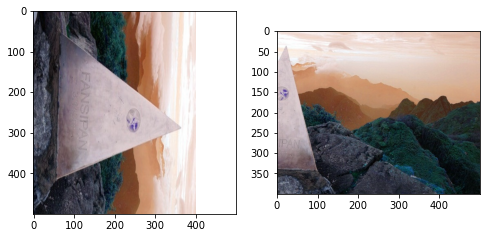

In [21]:
rotated_left_fansipan = cv2.rotate(left_fansipan, cv2.cv2.ROTATE_90_CLOCKWISE)
show_images(rotated_left_fansipan, right_fansipan)

In [22]:
rotated_left_fansipan.shape, left_fansipan.shape

((500, 400, 3), (400, 500, 3))

Hai ảnh khác nhau về chiều cao chắc chắn sẽ bị lỗi, `thuật toán không hoạt động với ảnh được xoay`

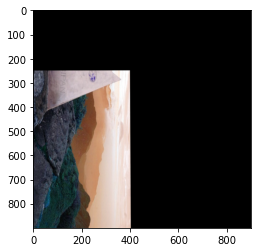

In [23]:
stitcher = Stitcher(final_image=False, rotated=True)
rotated_stitched = stitcher.stitch(right_fansipan, rotated_left_fansipan)
plt.imshow(rotated_stitched)
plt.show()
# vẫn tính được ma trận homography vì cơ bản SIFT bất biến với các phép biến đổi
# sau đó có các matched keypoints tương ứng thì sẽ tính được ma trận homography
# lúc này chỉ việc gán pixel phần trên cho ảnh được nối

#### Độ sáng

In [24]:
stitcher = Stitcher()

In [25]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

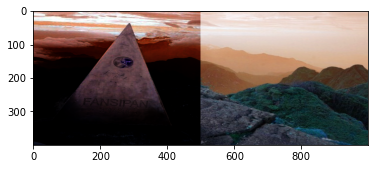

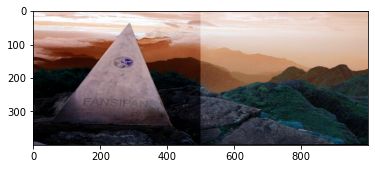

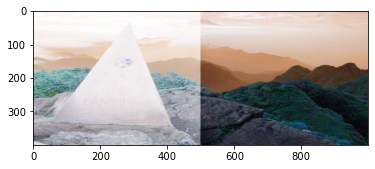

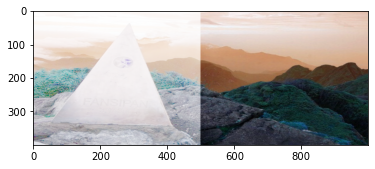

In [26]:
for gamma in [0.2, 0.5, 4.0, 5.0]:
    adjusted = adjust_gamma(left_fansipan, gamma=gamma)
    illuminated = stitcher.stitch(right_fansipan, adjusted)
    plt.imshow(illuminated)
    plt.show()

`Độ sáng thay đổi thì thuật toán vẫn hoạt động tốt!`

#### Kết luận:
Thuật toán **nhạy cảm**(không đảm bảo ghép ảnh thành công) với các yếu tố sau:

1. `Thứ tự ảnh cũng như số lượng ảnh`
2. `Ảnh với các phép biến đổi làm kích thước khác đi`
3. `Ảnh nhiễu tức là ảnh không trùng với một khung trong panorama`

Vào năm 2007, Brown và Lowe đề xuất bài báo:
[Automatic Panoramic Image Stitching with Invariant Features](http://matthewalunbrown.com/papers/ijcv2007.pdf)

`Ưu điểm là sẽ khắc phục các nhược điểm trên`

In [27]:
stitcher = cv2.Stitcher_create() # thuật toán được cài đặt như trong bài báo

0


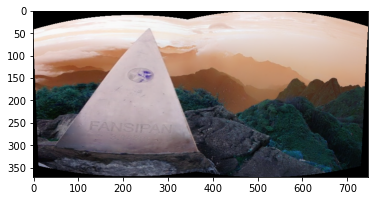

In [34]:
images = [right_fansipan, left_fansipan]
(status, stitched) = stitcher.stitch(images)
if status == cv2.STITCHER_OK:
    plt.imshow(stitched)
print(status) # 0:stitching success

Cơ bản hàm ở dưới sẽ làm hình hiển thị đẹp hơn - xoá bỏ viền đen và xoá phần ảnh ít nhất có thể!

In [35]:
def better_plot(stitched):
    stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10, cv2.BORDER_CONSTANT)
    gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)

    mask = np.zeros(thresh.shape, dtype='uint8')
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

    minRect = mask.copy()
    sub = mask.copy()

    while cv2.countNonZero(sub) > 0:
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)

    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
    return stitched[y:y + h, x:x + w]

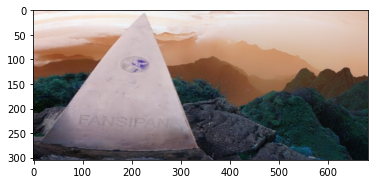

In [36]:
stitched = better_plot(stitched)
plt.imshow(stitched)
plt.show()

`Thuật toán hoạt động tốt`

Tuy nhiên, thuật toán chỉ hoạt động tốt khi có nhiều ảnh

In [37]:
(status, stitched) = stitcher.stitch(images)
if status == cv2.STITCHER_OK:
    plt.imshow(stitched)
print(status) # 1: cần thêm nhiều ảnh hơn
# ít ảnh đôi khi tính toán sẽ thất bại

1


Như vậy, thuật toán mới giải quyết được vấn đề khi có nhiều ảnh

In [38]:
imgPaths = paths.list_images('images/countryside')

In [39]:
images = [cv2.imread(imgPath) for imgPath in sorted(imgPaths)]
left_countryside, middle_countryside, right_countryside, countryside = images

In [40]:
def show_three_images(A, B, C, figsize=(8, 5)):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    ax1.imshow(A)
    ax2.imshow(B)
    ax3.imshow(C)
    plt.show()

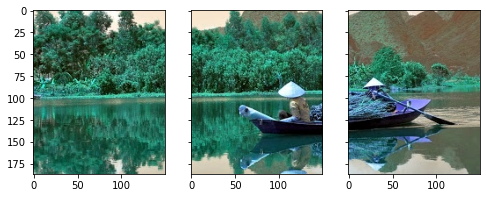

In [41]:
show_three_images(left_countryside, middle_countryside, right_countryside)

In [42]:
stitcher = cv2.Stitcher_create()

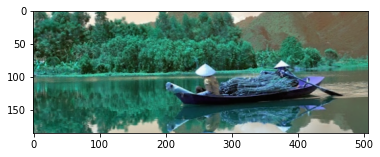

In [43]:
(status, stitched) = stitcher.stitch(images)
if status == cv2.STITCHER_OK:
    stitched = better_plot(stitched)
    plt.imshow(stitched)

`Thuật toán mới cải tiến khá tốt`


#### Thử nghiệm

#### Thứ tự

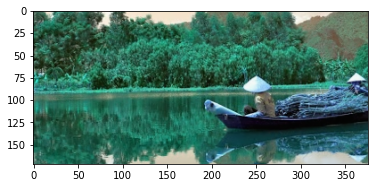

In [44]:
images = [middle_countryside, right_countryside, left_countryside]
(status, stitched) = stitcher.stitch(images)
if status == cv2.STITCHER_OK:
    stitched = better_plot(stitched)
    plt.imshow(stitched)

`Thứ tự ảnh là không quan trọng!!`, không cần trùng trái sang trùng phải

#### Ảnh nhiễu

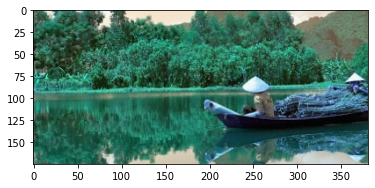

In [45]:
images = [middle_countryside, right_countryside, left_fansipan, left_countryside, right_fansipan]
# ở đây có hai ảnh không liên quan
(status, stitched) = stitcher.stitch(images)
if status == cv2.STITCHER_OK:
    stitched = better_plot(stitched)
    plt.imshow(stitched)

`Giải quyết được vấn đề ảnh nhiễu!!`, ảnh nhiễu ở đây là ảnh không thuộc có phần nào trùng với panorama

#### Ảnh với các phép biến đổi khác nhau

In [46]:
resized_left_countryside = cv2.resize(left_countryside, (300, 230)) # ban đầu là (187, 250)
rotated_middle_countryside = cv2.rotate(middle_countryside, cv2.cv2.ROTATE_90_CLOCKWISE)
illuminated_right_countryside = adjust_gamma(right_countryside, gamma=2.0)

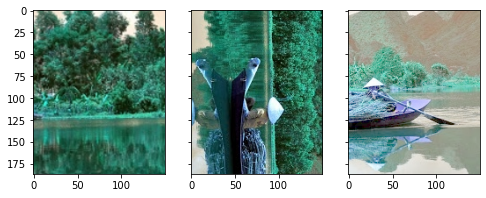

In [47]:
show_three_images(resized_left_countryside, rotated_middle_countryside, illuminated_right_countryside)

0


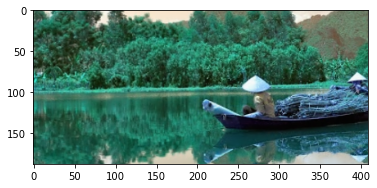

In [48]:
images = [middle_countryside, illuminated_right_countryside, resized_left_countryside]
# chưa sử dụng ảnh xoay
(status, stitched) = stitcher.stitch(images)
if status == cv2.STITCHER_OK:
    stitched = better_plot(stitched)
    plt.imshow(stitched)
print(status)

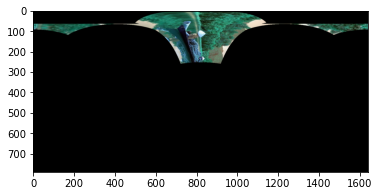

In [49]:
images = [illuminated_right_countryside, resized_left_countryside, rotated_middle_countryside]
# sử dụng ảnh xoay
(status, stitched) = stitcher.stitch(images)
if status == cv2.STITCHER_OK:
#     stitched = better_plot(stitched)
    plt.imshow(stitched)

`Thuật toán vẫn chạy thành công, về mặt hiển thị thì không ổn lắm`

Thuật toán stitching mới không bị **nhạy cảm** về các ảnh được biến đổi

### Kết luận

`Automatic Panorama Stitching` cải tiến về việc tự động hoá mọi thứ từ vét cạn các cặp ảnh với nhau để so khớp, loại bỏ ảnh nhiễu cũng như không bị nhạy cảm với các ảnh bị biến đổi(phép phóng to, thu nhỏ, xoay,..) <br>
`Nhược điểm` là ảnh cần đủ nhiều để thực hiện việc so khớp và không trả về ma trận homography <br>
`Manual Panorama Stiching` cần phải cài đặt thuật thủ công tay, đảm bảo thứ ảnh so khớp và bị nhạy cảm với các các ảnh bị biến đổi <br>
`Như vậy, nếu so khớp thông thường thì sử dụng Automatic Panorama Stitching vì nó nhanh chóng và dễ sử dụng` <br>
`Tuy nhiên, nếu cần sử dụng đến ma trận homography thì phải dùng cách thủ công. Chẳng hạn trong bài toán real-time panorma - sử dụng camera để so khớp`

### Nguồn tham khảo
[Image Stitching with Python and OpenCV](https://www.pyimagesearch.com/2018/12/17/image-stitching-with-opencv-and-python/) <br>
[OpenCV Panorama Matching](https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/) <br>
[Illumination](https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/) 